# Basic Documentation

The sole purpose of this notebook is to gradually present the features of **jaxKAN**, starting from the B-splines and ending with networks of KAN Layers. To run some cells of this notebook, libraries not included in `requirements.txt` are necessary. These are:

```
torch==2.3.0
matplotlib==3.8.4
```

Note that all tests were performed for CPU (hence why we're installing torch and jax for CPU). GPU tests may also be available in the future, although going from CPU to GPU in JAX is more than straightforward.

## Basis Functions: Splines

The basis functions used to expand the activation functions are B-spline basis functions and their generation is handled by `bases/splines.py`. A B-spline basis is constructed using only a knot vector for a given spline order, $k$. In the present implementation, the concept of the knot vector is extended to the "grid", which is simply a collection of knot vectors per B-spline activation. The reason why a single knot vector is not utilized for all splines is because the choice of knot vector is data-dependent, so each different feature of the data requires its own knot vector, thus resulting in a grid of different knot vectors. Before diving into the specifics of KANs, let's visualize the spline basis for different values of $k$ and a uniform knot vector.

In [1]:
import jax.numpy as jnp

# Number of intervals in the knot vector
G = 3
# Knot vector's ends
T = [0, 3]

For a given value of $k$, the knot vector is *augmented* by (uniformly) adding $k$ points to its left and $k$ points to its right. This augmentation turns the knot vector from $G+1$-dimensional to $G+2k+1$-dimensional. The function defined below creates a grid based on an augmented knot vector.

In [2]:
def get_grid(size, T, G, k):
    # Knot vector augmentation process
    h = (T[-1] - T[0]) / G
    grid = (jnp.arange(-k, G + k + 1, dtype=jnp.float32) * h + T[0])
    # Expand from (G+2k+1) to (size, G+2k+1)
    grid = jnp.expand_dims(grid, axis=0)
    grid = jnp.tile(grid, (size, 1))
    return grid

The `size` parameter is supposed to be $n_{in} \cdot n_{out}$ for a KAN Layer, corresponding to the number of the layer's different spline activations, but for our tests we can simply set it to 1.

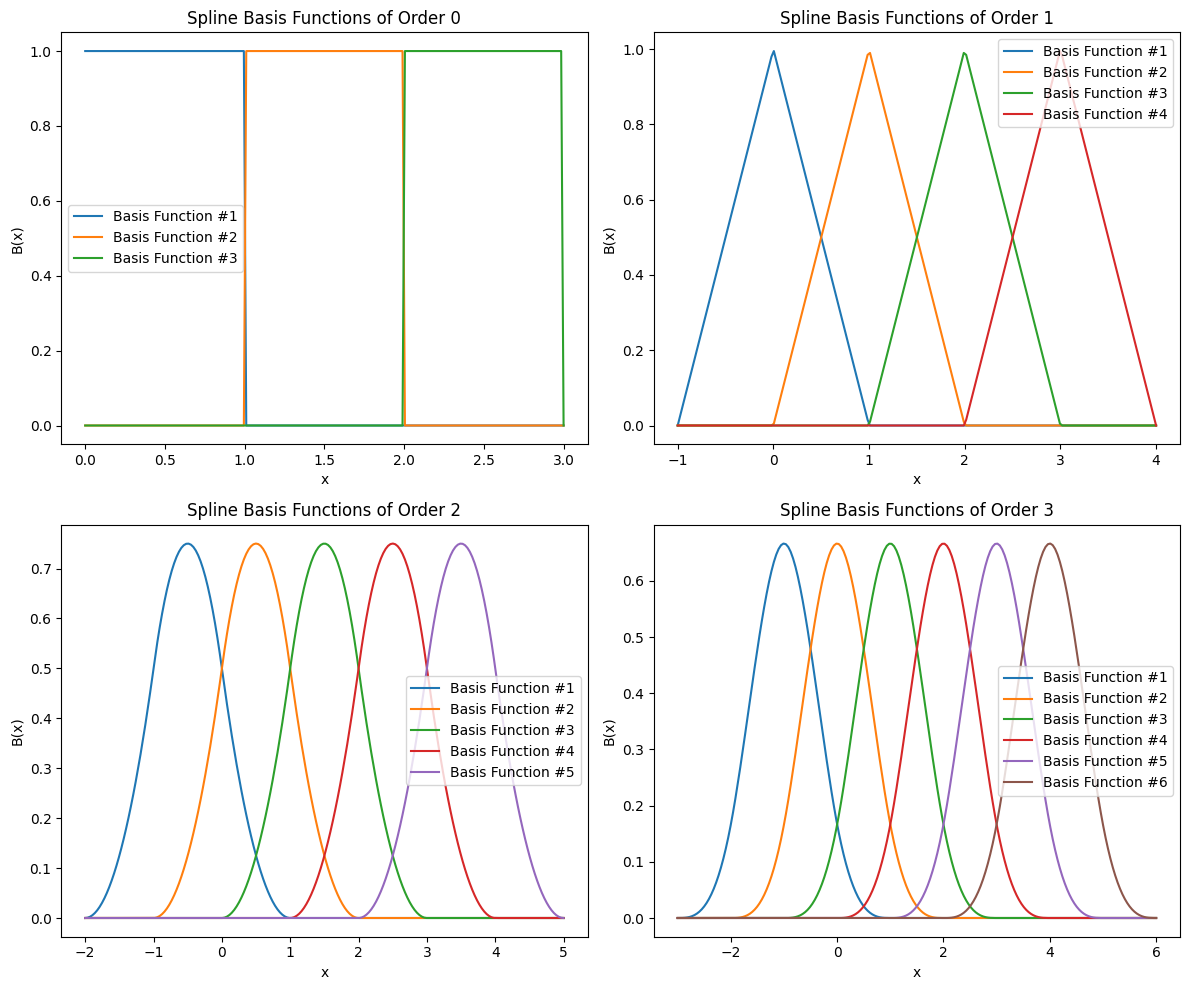

In [3]:
from jaxkan.bases.splines import get_spline_basis

import matplotlib.pyplot as plt

k_values = [0, 1, 2, 3]
num_x = 200

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, k in enumerate(k_values):
    grid = get_grid(1, T, G, k)

    # Get xs
    x = jnp.linspace(grid[0, 0], grid[0, -1], num_x)
    x_reshaped = x.reshape((num_x, 1))

    # Call the function
    basis_splines = get_spline_basis(x_reshaped, grid, k)

    # Reshape
    funcs = basis_splines.reshape((x_reshaped.shape[0], basis_splines.shape[-2]))

    # Determine the subplot position
    ax = axes[idx // 2, idx % 2]
    
    for i in range(funcs.shape[1]):
        ax.plot(x, funcs[:, i], label=f'Basis Function #{i + 1}')

    # Adding labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('B(x)')
    ax.set_title(f'Spline Basis Functions of Order {k}')
    ax.legend()

plt.tight_layout()
plt.show()

The results shown above are expected. For a given grid of $G+2k+1$ points, the number of spline basis functions is equal to $G+k$, so for $k=0$ we get $G+0=3$ spline basis functions, for $k=1$ we get $G+1=4$ spline basis functions, and so on.

## Utilities: Least Squares Algorithm

The `utils.py` file holds two utility functions, designed to run the least squares algorithm for batched inputs, i.e. matrices of shape $(batch,M,N)$ and $(batch,M,K)$. While this functionality is already built-in for PyTorch, JAX's version of `jax.numpy.linalg.lstsq` does not accept batch-application of the Least Squares algorithm. In what follows, we show some examples and perform some tests.

In [4]:
import torch

from jaxkan.utils.general import solve_full_lstsq

# Set a manual seed for reproducibility
torch.manual_seed(42)

batch, M, N = 10, 100, 30

A = torch.randn(batch, M, N)
B = torch.randn(batch, M, 1)

# Get the same matrices to compare results
jA, jB = jnp.array(A.numpy()), jnp.array(B.numpy())

torch_sol = torch.linalg.lstsq(A, B).solution
jax_sol = solve_full_lstsq(jA, jB)

# Compare results
assert jnp.allclose(jax_sol, torch_sol.numpy(), atol=1e-5), "The solutions do not match!"

No assertion error occurs, which implies that the two solutions are equivalent (up to 5th decimal precision). It would now perhaps be interesting to time the execution of the two approaches and compare.

In [5]:
import time

# Function to time the torch implementation
def time_torch_lstsq(A, B, reps):
    start_time = time.time()
    for _ in range(reps):
        torch_sol = torch.linalg.lstsq(A, B).solution
    torch_time = (time.time() - start_time)/reps
    return torch_time

# Function to time the jax implementation
def time_jax_lstsq(jA, jB, reps):
    # A warm-up run to ensure that the code has been compiled, because
    # when jax.jitting the first run is always slow
    jax_sol = solve_full_lstsq(jA, jB)

    # Now start timing
    start_time = time.time()
    for _ in range(reps):
        jax_sol = solve_full_lstsq(jA, jB)
    jax_time = (time.time() - start_time)/reps

    return jax_time

Let's first try a large batch size.

In [7]:
batch, M, N = 1000, 50, 50

A, B = torch.randn(batch, M, N), torch.randn(batch, M, 1)
jA, jB = jnp.array(A.numpy()), jnp.array(B.numpy())

torch_time = time_torch_lstsq(A, B, 10)
jax_time = time_jax_lstsq(jA, jB, 10)

print(f"The average execution time for the JAX version is {jax_time:.4f} seconds.")
print(f"The average execution time for the PyTorch version is {torch_time:.4f} seconds.")

The average execution time for the JAX version is 0.0371 seconds.
The average execution time for the PyTorch version is 0.0505 seconds.


JAX appears to be faster. Let's now try to decrease the batch size and increase the matrix dimensions.

In [10]:
batch, M, N = 100, 400, 400

A, B = torch.randn(batch, M, N), torch.randn(batch, M, 1)
jA, jB = jnp.array(A.numpy()), jnp.array(B.numpy())

torch_time = time_torch_lstsq(A, B, 10)
jax_time = time_jax_lstsq(jA, jB, 10)

print(f"The average execution time for the JAX version is {jax_time:.4f} seconds.")
print(f"The average execution time for the PyTorch version is {torch_time:.4f} seconds.")

The average execution time for the JAX version is 0.2728 seconds.
The average execution time for the PyTorch version is 0.0982 seconds.


In this case, PyTorch achieves better results. So, as a rule of thumb, we could perhaps say that the JAX implementation is better optimized for large batches (perhaps due to the use of vmap), while the PyTorch implementation is better optimized for large matrices (perhaps due to the fact that the JAX implementation does costly matrix transpositions and multiplications under the hood). In any case, the results are comparable and therefore the JAX implementation is good, especially when considering that this process is not required for every training epoch.

## KANLayer

After these preliminaries, we may proceed to the concept of the KAN Layer. Each KAN Layer is defined by the number of its input nodes ($n_{in}$) and the number of its output nodes ($n_{out}$). Apart from its initialization and forward pass, it also includes a method which is relevant to the grid update which is supposed to occur periodically. After this update, the number of spline basis functions changes (because $G$ is now larger), therefore the basis coefficients need to be re-initialized. However, we do not re-initialize them from random values (otherwise all preceding training would be useless): instead, we perform the least squares algorithm to ensure that their initialization is such, that the corresponding spline activations are as close as possible to those before the grid was updated.

In [12]:
import jax

from jaxkan.models.KANLayer import KANLayer

n_in = 2
n_out = 3

# Get a random input
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (50, n_in))

# Define the layer
kan_layer = KANLayer(n_in=n_in, n_out=n_out)

# Initialize the layer
variables = kan_layer.init(key, x)

The `variables` object is a dictionary corresponding to the layer's variables. These variables are split in two categories: `state` variables, which correspond to non-trainable parameters and `param` variables, which correspond to trainable parameters. In this case, the grid corresponding to this layer is a `state` variable, while the spline basis coefficients (`c_basis`), the spline activation constants (`c_spl`) and the residual activation constants (`s_res`) are trainable `params`. The below defined function allows us to get a glimpse of the hierarchy of such dicts, as well as the shapes of the arrays they contain.

In [13]:
def print_dict_hierarchy(d, indent=0):
    for key, value in d.items():
        if isinstance(value, dict):
            print(' ' * indent + str(key))
            print_dict_hierarchy(value, indent + 4)
        else:
            print(' ' * indent + f"{key}: shape {value.shape}")

In [14]:
print_dict_hierarchy(variables)

state
    grid: shape (6, 10)
params
    c_basis: shape (6, 6)
    c_spl: shape (6,)
    c_res: shape (6,)


By default, the first initialization of the grid is performed using $G = 3$ and $k = 3$ is selected if another $k$ argument is not passed. So, the shapes shown above make perfect sense: the grid is shaped `(n_in*n_out, G+2k+1)`, the spline basis coefficients are shaped `(n_in*n_out, G+k)` and the `c_spl` and `c_res` parameters are shaped `(n_in*n_out,)`.

To perform a forward pass using this layer, we simply use the default `apply` method, passing the variables dict as well as the argument, `x`.

In [15]:
y, spl = kan_layer.apply(variables, x)

The returned objects are `y`, the result of applying the layer on `x`, as well as `spl`, which is necessary for the regularization term of the loss function (see arXiv preprint, Eqs. 2.17 - 2.20).

In [16]:
print(f"The shape of y is {y.shape}, i.e. (batch_size, n_out).")
print(f"The shape of spl is {spl.shape}, i.e. (n_out, n_in).")

The shape of y is (50, 3), i.e. (batch_size, n_out).
The shape of spl is (3, 2), i.e. (n_out, n_in).


Let's now perform a grid update for this layer, switching from $G=3$ to $G^\prime = 5$. Again, the `apply` method is used, this time passing `mutable=['state']` as an argument, so that the grid is updated internally for the layer and returned as a new state variable.

In [17]:
G_new = 5
new_coeffs, new_state = kan_layer.apply(variables, x, G_new, method=kan_layer.update_grid, mutable=['state'])

print(f"The shape of the new coefficients array is {new_coeffs.shape}, i.e. (n_in*n_out, G'+k).")

The shape of the new coefficients array is (6, 8), i.e. (n_in*n_out, G'+k).


The `new_coeffs` object contains an array of the coefficients corresponding to the new grid, hence their shape. As for the `new_state` object, it's a dictionary which returns the new grid.

In [18]:
print_dict_hierarchy(new_state)

state
    grid: shape (6, 12)


As we can confirm, the new grid is shaped `(n_in*n_out, G'+2k+1)`, as it should. Of course, the grid is not an internal property of the layer; in fact, due to the way Flax works, none of the variables is. This can be confirmed if we perform a forward pass with the model after the grid's update.

In [19]:
y_new, _ = kan_layer.apply(variables, x)

# Compare y with y_new
assert jnp.allclose(y_new, y, atol=1e-5), "The solutions do not match!"

Again, no assertion error occurs, which means that `y` and `y_new` are the same. So, how can we inform the layer that the grid has changed? We simply pass the correct variables directory when calling any `apply` method! Notice how for the above forward pass we passed the `variables` dict without applying the changes that came from `new_coeffs` and `new_state`. Let's combine them to create a `new_variables` dict.

In [20]:
new_variables = variables.copy()
new_variables['state'] = new_state['state']
new_variables['params']['c_basis'] = new_coeffs

y_newer, _ = kan_layer.apply(new_variables, x)

# Compare y with y_newer
assert jnp.allclose(y_newer, y, atol=1e-5), "The solutions do not match!"

AssertionError: The solutions do not match!

Indeed, we get the assertion error we hoped for! So the idea here is passing dictionaries back and forth when we need to apply internal parameter updates.

## KAN

Based on the above, moving from a KANLayer to a KAN is pretty straightforward. A KAN with $F$ layers can be defined as a collection of KANLayers using an argument of the form `layer_dims = [n_0, n_1, ..., n_F]` where $n_i$ is the number of input nodes and $n_{i+1}$ is the number of output nodes for layer $i$. The full network's forward pass corresponds to consecutive passes through each of its layers (with the optional inclusion of a bias term), while a grid update for the KAN corresponds to a grid update for each of its layers. Of course, the dictionaries updates and passing is performed automatically here for the interior layers.

In [21]:
from jaxkan.models.KAN import KAN

layer_dims = [4, 5, 2, 1]
model = KAN(layer_dims=layer_dims, k=3, add_bias=True)

x = jax.random.normal(key, (50, 4))

variables = model.init(key, x)

In [22]:
print_dict_hierarchy(variables)

params
    bias_0: shape (5,)
    bias_1: shape (2,)
    bias_2: shape (1,)
    layers_0
        c_basis: shape (20, 6)
        c_spl: shape (20,)
        c_res: shape (20,)
    layers_1
        c_basis: shape (10, 6)
        c_spl: shape (10,)
        c_res: shape (10,)
    layers_2
        c_basis: shape (2, 6)
        c_spl: shape (2,)
        c_res: shape (2,)
state
    layers_0
        grid: shape (20, 10)
    layers_1
        grid: shape (10, 10)
    layers_2
        grid: shape (2, 10)


The model's initialization handles each constituent layer's initialiation and all state and param variables are logged in a universal `variables` dictionary.

In [23]:
y, spl_regs = model.apply(variables, x)

print(f"The input's shape is {x.shape}, consistent with the first layer's input dimension.")
print(f"The output's shape is {y.shape}, consistent with the last layer's output dimension.")
print(f"The length of the spl_reg list is {len(spl_regs)}, consistent with len(layer_dims)-1.\nIts constituent arrays are shaped:")
for idx, item in enumerate(spl_regs):
    print(f"\tLayer No. {idx+1}: Shape {item.shape}.")

The input's shape is (50, 4), consistent with the first layer's input dimension.
The output's shape is (50, 1), consistent with the last layer's output dimension.
The length of the spl_reg list is 3, consistent with len(layer_dims)-1.
Its constituent arrays are shaped:
	Layer No. 1: Shape (5, 4).
	Layer No. 2: Shape (2, 5).
	Layer No. 3: Shape (1, 2).


As we can see, the `spl_regs` outputs' dimensions are also consistent with the network's layers' dimensions. So let's check the grid update process in terms of the entire network.

In [24]:
G_new = 5
updated_variables = model.apply(variables, x, G_new, method=model.update_grids)

This method returns the updated variables, to be used directly for the next model's application.

In [25]:
print_dict_hierarchy(updated_variables)

params
    bias_0: shape (5,)
    bias_1: shape (2,)
    bias_2: shape (1,)
    layers_0
        c_basis: shape (20, 8)
        c_spl: shape (20,)
        c_res: shape (20,)
    layers_1
        c_basis: shape (10, 8)
        c_spl: shape (10,)
        c_res: shape (10,)
    layers_2
        c_basis: shape (2, 8)
        c_spl: shape (2,)
        c_res: shape (2,)
state
    layers_0
        grid: shape (20, 12)
    layers_1
        grid: shape (10, 12)
    layers_2
        grid: shape (2, 12)


All updated shapes are consistent with the $G=3 \to G^\prime = 5$ update. Note that, thanks to the way we're performing the updates inside KAN (using `unfreeze` when calling from `self.scope`), the updates do not occur in-place, i.e. the `variables` object is returned unchanged:

In [26]:
print_dict_hierarchy(variables)

params
    bias_0: shape (5,)
    bias_1: shape (2,)
    bias_2: shape (1,)
    layers_0
        c_basis: shape (20, 6)
        c_spl: shape (20,)
        c_res: shape (20,)
    layers_1
        c_basis: shape (10, 6)
        c_spl: shape (10,)
        c_res: shape (10,)
    layers_2
        c_basis: shape (2, 6)
        c_spl: shape (2,)
        c_res: shape (2,)
state
    layers_0
        grid: shape (20, 10)
    layers_1
        grid: shape (10, 10)
    layers_2
        grid: shape (2, 10)


This simply means that we have to pass the `updated_variables` dict in the next model application.